In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [3]:
df = pd.read_csv('Gold Price (2013-2023).csv')

In [4]:
df

,Date,Price,Open,High,Low
0,01-01-2013,30850,30750,30900,30700
1,07-01-2013,30550,30500,30600,30450
2,13-01-2013,30800,30750,30850,30750
3,19-01-2013,31000,30950,31050,30900
4,25-01-2013,31200,31150,31250,31100
...,...,...,...,...,...
659,03-12-2023,63100,63050,63200,62950
660,09-12-2023,63250,63200,63350,63100
661,15-12-2023,63400,63350,63500,63250
662,21-12-2023,63550,63500,63650,63400


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664 entries, 0 to 663
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    664 non-null    object
 1   Price   664 non-null    int64 
 2   Open    664 non-null    int64 
 3   High    664 non-null    int64 
 4   Low     664 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 26.1+ KB


In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [8]:
NumCols = df.columns.drop(['Date'])
df[NumCols] = df[NumCols].replace({',': ''}, regex=True)
df[NumCols] = df[NumCols].astype('float64')

In [9]:
df.head()

,Date,Price,Open,High,Low
0,2013-01-01,30850.0,30750.0,30900.0,30700.0
1,2013-01-07,30550.0,30500.0,30600.0,30450.0
2,2013-01-13,30800.0,30750.0,30850.0,30750.0
3,2013-01-19,31000.0,30950.0,31050.0,30900.0
4,2013-01-25,31200.0,31150.0,31250.0,31100.0


In [10]:
df.duplicated().sum()

0

In [11]:
df.isnull().sum().sum()

0

In [12]:
fig = px.line(y=df.Price, x=df.Date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(255,223,0,0.8)')

In [13]:
test_size = df[df.Date.dt.year==2022].shape[0]
test_size

61

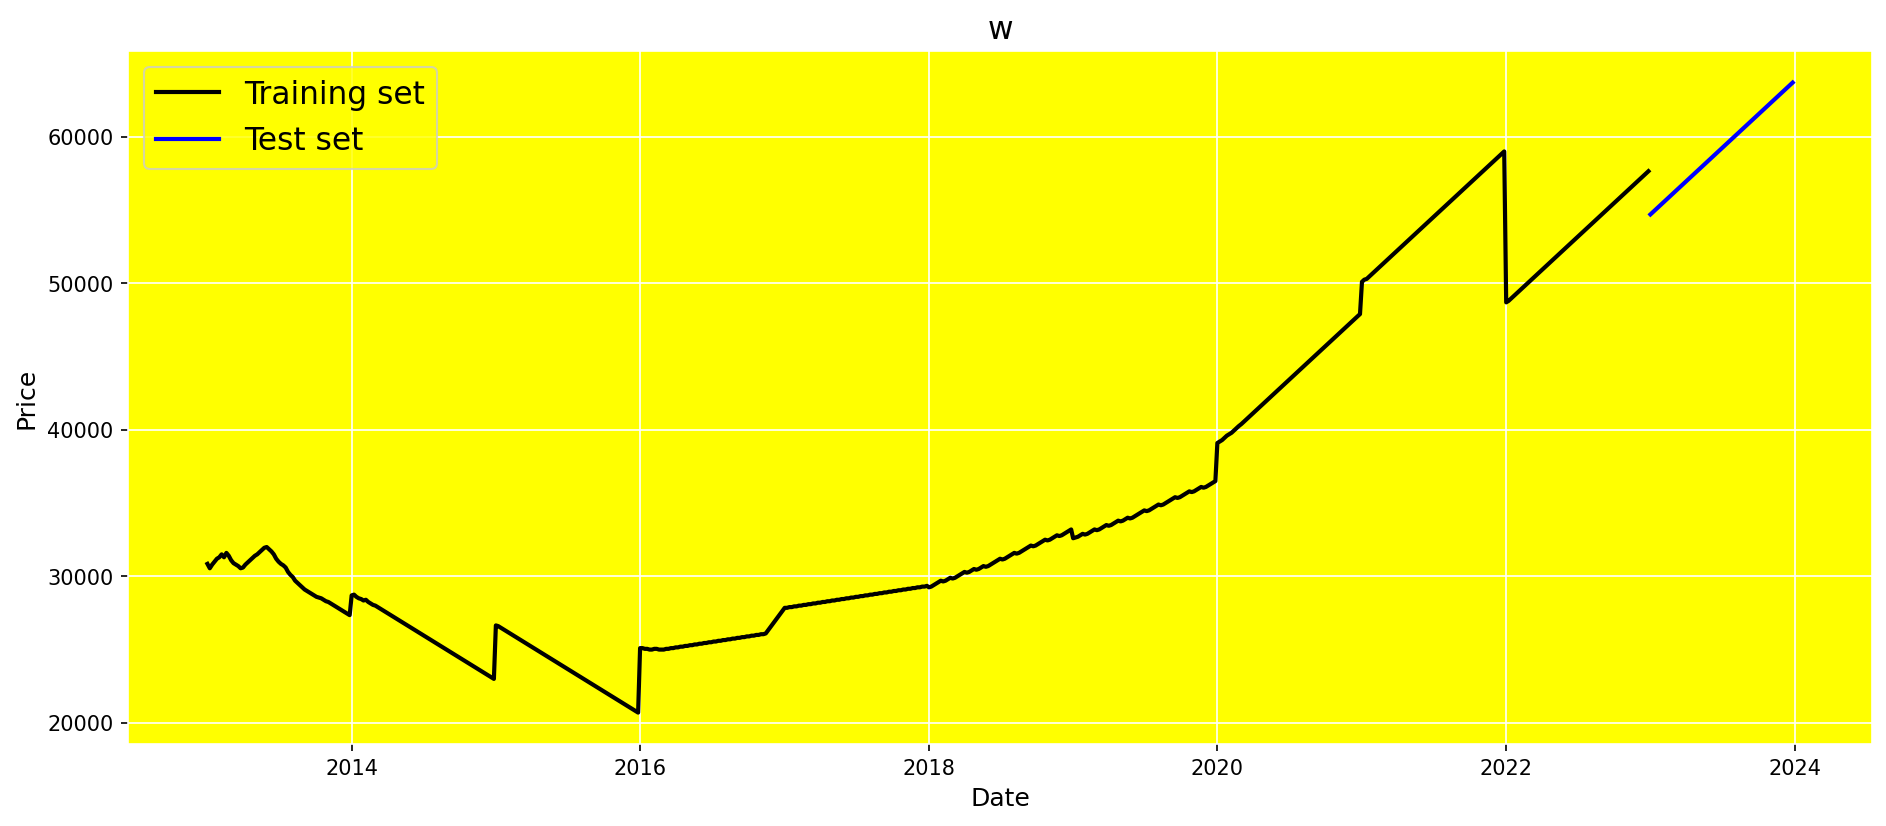

In [14]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df.Date[:-test_size], df.Price[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Price[-test_size:], color='blue', lw=2)
plt.title('w', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [15]:
scaler = MinMaxScaler()
scaler.fit(df.Price.values.reshape(-1,1))

MinMaxScaler()

In [16]:
window_size = 60

In [17]:
train_data = df.Price[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [18]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [19]:
test_data = df.Price[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [20]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [21]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [22]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [23]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (543, 60, 1)
y_train Shape:  (543, 1)
X_test Shape:   (61, 60, 1)
y_test Shape:   (61, 1)


In [24]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

In [25]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - loss: 0.1755 - val_loss: 0.2505
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0592 - val_loss: 0.1940
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0410 - val_loss: 0.1609
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0322 - val_loss: 0.1378
Epoch 5/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0210 - val_loss: 0.1186
Epoch 6/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0184 - val_loss: 0.1022
Epoch 7/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0175 - val_loss: 0.0890
Epoch 8/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0154 - val_loss: 0.0774
Epoch 9/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0119 - val_loss: 0.0678
Epoch 10/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0116 - val_loss: 0.0586
Epoch 11/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0085 - val_loss: 0.0509
Epoch 12/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/st

In [26]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0083
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 808ms/step


In [27]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [28]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.011397141963243484
Test MAPE: 0.09307149476376982
Test Accuracy: 0.9069285052362301


In [29]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

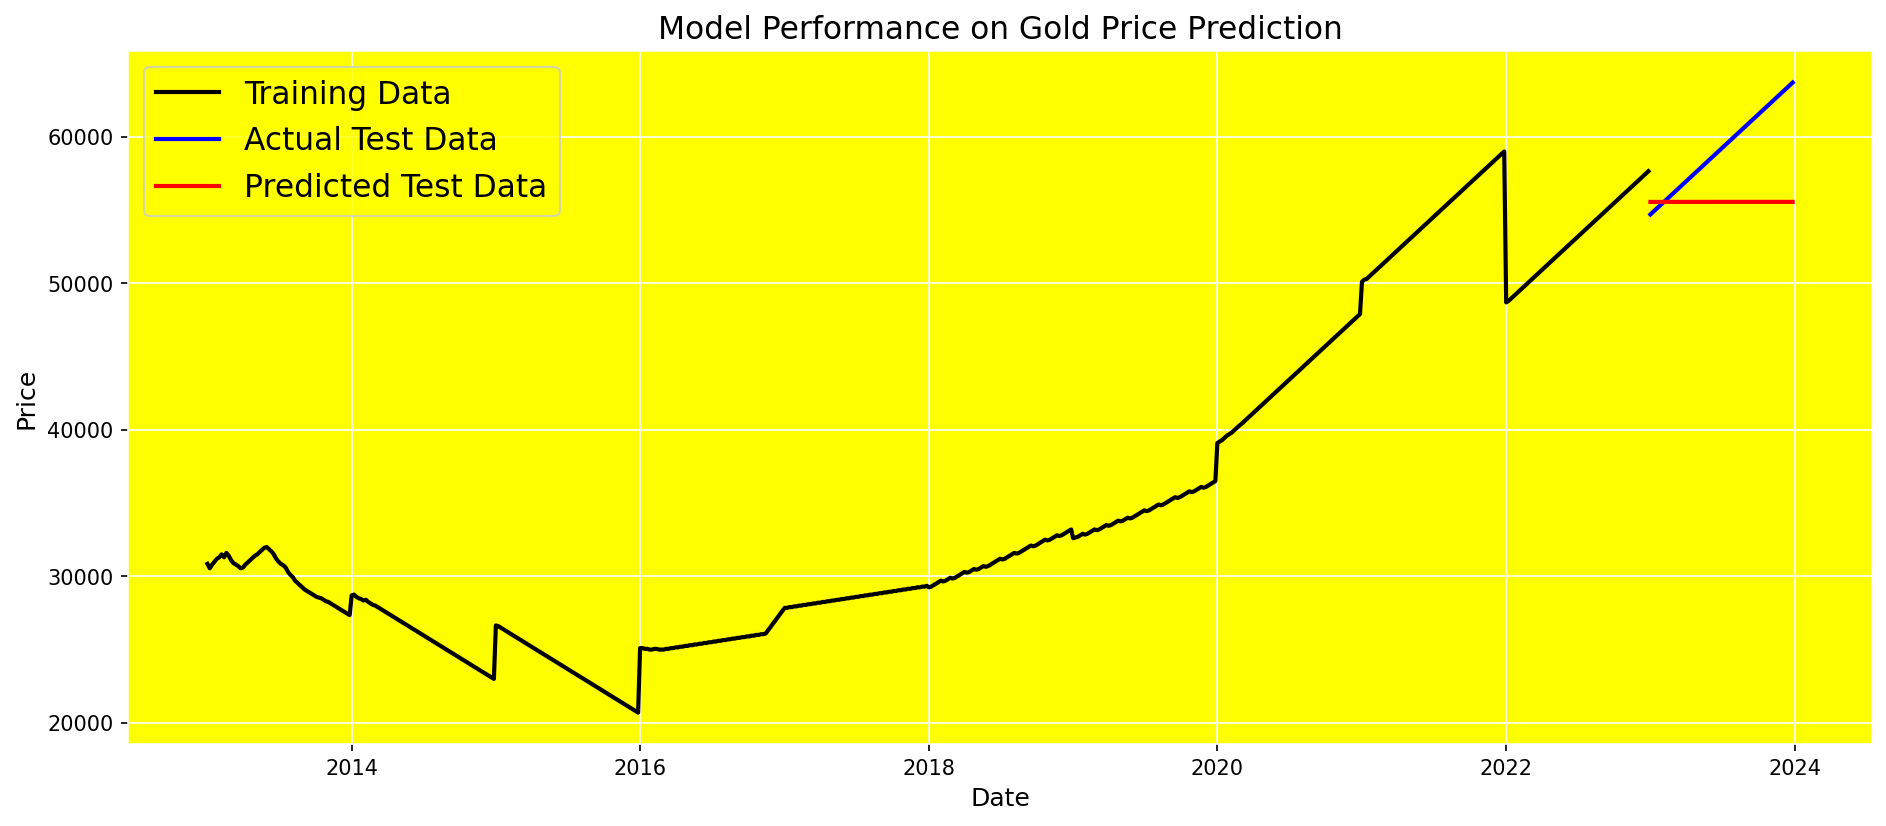

In [30]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [32]:
from keras.saving import save_model
save_model(model, 'GoldModel.keras')


In [33]:
# Prediction function
def predict_gold_price(date):
    date = pd.to_datetime(date)
    if date < df['Date'].min():
        index = 0
    elif date > df['Date'].max():
        index = df.shape[0] - 60
    else:
        index = df[df['Date'] >= date].index[0]
    input_data = df['Price'][index - window_size:index].values
    input_data = scaler.transform(input_data.reshape(-1, 1).reshape(1, -1)).reshape(1, -1, 1)
    prediction = model.predict(input_data)
    prediction = scaler.inverse_transform(prediction)
    return prediction[0][0]


In [34]:
# Fit scaler on the 'Price' column
scaler.fit(df[['Price']])

def predict_gold_price(date):
    date = pd.to_datetime(date)
    if date < df['Date'].min():
        index = 0
    elif date > df['Date'].max():
        index = df.shape[0] - window_size
    else:
        index = df[df['Date'] >= date].index[0]

    # Ensure the index is within bounds
    index = max(window_size, min(index, df.shape[0] - 1))
    input_data = df['Price'][index - window_size:index].values

    # Reshape and scale the input data
    input_data = input_data.reshape(-1, 1)
    input_data = scaler.transform(input_data).reshape(1, window_size, 1)
    
    # Predict and inverse transform the result
    prediction = model.predict(input_data)
    prediction = scaler.inverse_transform(prediction)
    return prediction[0][0]

user_date = input("Enter a date (YYYY-MM-DD) to predict the gold price: ")
predicted_price = predict_gold_price(user_date)
print(f"The predicted gold price for {user_date} is: {predicted_price}")

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
The predicted gold price for 2023-11-02 is: 55558.45703125
